In [1]:
# Here I define the stock I want to work on.
# If you simply change the name and re-run the whole notebook the whole process will be done automatically.
# For example if I want to load Google.csv I type in 'Google'.
# This is NOT case sensitive. 
stock = 'Google'

## Loading Data

In [2]:
import numpy as np
import pandas as pd
df1 = pd.read_csv(f'{stock}.csv')
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [3]:
# I use the daily adjusted close prices. These prices are adjusted for possible dividends and/or splits.
df = pd.DataFrame()
df[['Date', f'{stock}']] = df1[['Date', 'Adj Close']]
df.head()

,Date,Google
0,2004-08-19,49.982655
1,2004-08-20,53.952770
2,2004-08-23,54.495735
3,2004-08-24,52.239193
4,2004-08-25,52.802086


In [4]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3876 entries, 0 to 3875
Data columns (total 2 columns):
Date      3876 non-null object
Google    3876 non-null float64
dtypes: float64(1), object(1)
memory usage: 90.8+ KB


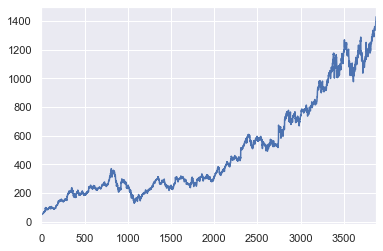

In [5]:
import matplotlib as plt
import seaborn as sns
sns.set()
df[f'{stock}'].plot()

## Checking for unit root
Before estimating any model, we have to check if the time series is stationary over time. If not then we take the first differences and check again. If not the second differences and so on. If the p-value of the test is lower than 0.05, then we reject the null hypothesis of non-stationarity.

In [6]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df[f'{stock}'])
print("The p-value of the Augmented Dickey-Fuller test is " + str(round(adf[1], 3)))

The p-value of the Augmented Dickey-Fuller test is 0.997


In [7]:
df[f'D{stock}'] = df[f'{stock}'].diff()
df.head()

,Date,Google,DGoogle
0,2004-08-19,49.982655,NaN
1,2004-08-20,53.952770,3.970115
2,2004-08-23,54.495735,0.542965
3,2004-08-24,52.239193,-2.256542
4,2004-08-25,52.802086,0.562893


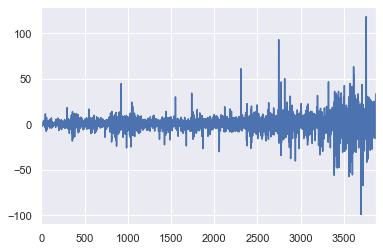

In [8]:
df[f'D{stock}'].plot()

In [9]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
adf = adfuller(df[f'D{stock}'])
print("The p-value of the Augmented Dickey-Fuller test is " + str(round(adf[1], 3)))

The p-value of the Augmented Dickey-Fuller test is 0.0


## Estimating the best ARIMA model for the mean
The first step before estimating the GARCH models is to estimate an ARIMA model for the mean. I estimate all models for orders p and q from 0 to 10 and take the model with the smallest AIC. All of the estimated coefficients should also be statistically significant.

In [11]:
# I am making use of the multiprocessing tool for faster estimation of the models.
# The map function takes 2 arguments. The first is the function I want to pool.
# The second is a list of the arguments for each process. Here I am creating that list.
# Each item of the list contains a list with 2 items.
# The first is the series I want to estimate the ARIMA model on.
# The second is the order q of the ARIMA model the process is going to estimate.
# So, the first process will estimate all ARIMA models for order p from 0 to 10 and q = 0 and return the best of them.
# The second process for p from 0 to 10 and q = 1 etc.
f = []
for i in range(11):
    f.append((df[f'{stock}'][:-3], i))

In [12]:
# For some reason the multiprocessing doesn't work if I define the function inside the Jupyter Notebook.
# So, I am calling the function from a separate file.
# Check gbam.py
# WARNING!!! This uses a lot of the CPU.
from gbam import gbam
import multiprocessing
if __name__ == '__main__':
    p = multiprocessing.Pool()
    results = p.map(gbam, f)
    p.close()

In [13]:
# Here I make a dataframe with the results from the pool.
# They are sorted by AIC.
aic1 = pd.DataFrame(results, columns=['AIC', 'Order'])
aic1.sort_values('AIC', inplace=True)
aic1.reset_index(inplace=True, drop=True)
#It is possible that some processes didn't find any models with the desired results so I delete them.
aic1.replace([np.inf, -np.inf], np.nan, inplace=True) 
aic1.dropna(inplace=True)
aic1

,AIC,Order
0,27981.1457,"(10, 8)"
1,28004.6839,"(6, 2)"
2,28029.6657,"(4, 1)"
3,28047.0913,"(0, 0)"


In [14]:
# The first row gives me the order of p and q with the lowest AIC.
p1 = aic1.iloc[0][1][0]
q1 = aic1.iloc[0][1][1]

In [15]:
# Saving the best order in a dictionary for later use.
pq = {}
pq.update({'ARIMA' : (p1 , q1)})

In [16]:
arima = ARIMA(df[f'{stock}'][:-3], order=(p1,1,q1)).fit()
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Google   No. Observations:                 3871
Model:                ARIMA(10, 1, 8)   Log Likelihood              -13970.573
Method:                       css-mle   S.D. of innovations              8.934
Date:                Mon, 27 Jan 2020   AIC                          27981.146
Time:                        20:16:34   BIC                          28106.371
Sample:                             1   HQIC                         28025.609
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3441      0.131      2.619      0.009       0.087       0.602
ar.L1.D.Google     -0.4194      0.034    -12.448      0.000      -0.485      -0.353
ar.L2.D.Google      0.1082      

## Estimating best GARCH model

In [17]:
# The same logic as the ARIMA model.
# This time the first item of each list is the residuals from the best ARIMA model.
# I also added a third item which is the method for estimating volatility.
# Check gbgm.py
f = []
for i in range(11):
    f.append((arima.resid, i, 'GARCH'))

In [18]:
# WARNING!!! This uses a lot of the CPU.
from gbgm import gbgm
if __name__ == '__main__':
    p = multiprocessing.Pool()
    results = p.map(gbgm, f)
    p.close()

In [19]:
aic2 = pd.DataFrame(results, columns=['AIC', 'Order'])
aic2.sort_values('AIC', inplace=True)
aic2.reset_index(inplace=True, drop=True)
aic2.replace([np.inf, -np.inf], np.nan, inplace=True)
aic2.dropna(inplace=True)
aic2

,AIC,Order
0,26038.5153,"(7, 0)"


In [20]:
p2 = aic2.iloc[0][1][0]
q2 = aic2.iloc[0][1][1]
pq.update({'GARCH' : (p2 , q2)})

In [21]:
from arch import arch_model
arma_garch = arch_model(arima.resid, p=p2, q=q2, mean='Zero', rescale=True).fit(disp='off')
print(arma_garch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -13011.3
Distribution:                  Normal   AIC:                           26038.5
Method:            Maximum Likelihood   BIC:                           26088.6
                                        No. Observations:                 3871
Date:                Mon, Jan 27 2020   Df Residuals:                     3863
Time:                        20:17:07   Df Model:                            8
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         11.0765      2.312      4.791  1.658e-06    [  

## Estimating best EGARCH model

In [22]:
f = []
for i in range(11):
    f.append((arima.resid, i, 'EGARCH'))

In [23]:
# WARNING!!! This uses a lot of the CPU.
if __name__ == '__main__':
    p = multiprocessing.Pool()
    results = p.map(gbgm, f)
    p.close()

In [24]:
aic3 = pd.DataFrame(results, columns=['AIC', 'Order'])
aic3.sort_values('AIC', inplace=True)
aic3.reset_index(inplace=True, drop=True)
aic3.replace([np.inf, -np.inf], np.nan, inplace=True)
aic3.dropna(inplace=True)
aic3

,AIC,Order
0,25589.4342,"(2, 1)"
1,26191.6798,"(10, 0)"


In [25]:
p3 = aic3.iloc[0][1][0]
q3 = aic3.iloc[0][1][1]
pq.update({'EGARCH' : (p3 , q3)})

In [26]:
from arch import arch_model
arma_egarch = arch_model(arima.resid, p=p3, q=q3, vol='EGARCH', mean='Zero', rescale=True).fit(disp='off')
print(arma_egarch.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -12790.7
Distribution:                  Normal   AIC:                           25589.4
Method:            Maximum Likelihood   BIC:                           25614.5
                                        No. Observations:                 3871
Date:                Mon, Jan 27 2020   Df Residuals:                     3867
Time:                        20:17:26   Df Model:                            4
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0144  7.856e-03      1.830  6.718e-02 

## Estimating best FIGARCH model

In [27]:
f = []
for i in range(11):
    f.append((arima.resid, i, 'FIGARCH'))

In [28]:
# WARNING!!! This uses a lot of the CPU.
if __name__ == '__main__':
    p = multiprocessing.Pool()
    results = p.map(gbgm, f)
    p.close()

In [29]:
aic4 = pd.DataFrame(results, columns=['AIC', 'Order'])
aic4.sort_values('AIC', inplace=True)
aic4.reset_index(inplace=True, drop=True)
aic4.replace([np.inf, -np.inf], np.nan, inplace=True)
aic4.dropna(inplace=True)
aic4

,AIC,Order
0,25711.9405,"(0, 1)"
1,25787.8595,"(0, 0)"


In [30]:
p4 = aic4.iloc[0][1][0]
q4 = aic4.iloc[0][1][1]
pq.update({'FIGARCH' : (p4 , q4)})

In [31]:
from arch import arch_model
arma_figarch = arch_model(arima.resid, p=p4, q=q4, vol='FIGARCH', mean='Zero', rescale=True).fit(disp='off')
print(arma_figarch.summary())

                      Zero Mean - FIGARCH Model Results                       
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -12853.0
Distribution:                  Normal   AIC:                           25711.9
Method:            Maximum Likelihood   BIC:                           25730.7
                                        No. Observations:                 3871
Date:                Mon, Jan 27 2020   Df Residuals:                     3868
Time:                        20:17:34   Df Model:                            3
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          4.1541      1.225      3.390  6.987e-04 [  1.752,  6.55

In [32]:
df['Variance'] = (df[f'D{stock}']-df[f'D{stock}'].mean())**2
fdf = pd.DataFrame()
fdf = df.tail(3).copy()
fdf.set_index('Date', drop=True, inplace=True)
fdf.head()

,Google,DGoogle,Variance
Date,,,
2020-01-08,1404.319946,10.979980,112.867595
2020-01-09,1419.829956,15.510010,229.642085
2020-01-10,1429.729980,9.900024,91.087176


In [33]:
df.reset_index(inplace=True, drop=True)

## Making 3 steps ahead forecast for each model

In [34]:
for i in range(1, len(pq)):
    g = []
    for j in range(1,4):
        farima = ARIMA(df[f'{stock}'][:-j], order=(p1,1,q2)).fit()
        fgarch = arch_model(farima.resid, p=list(pq.values())[i][0], q=list(pq.values())[i][1], vol=f'{list(pq.keys())[i]}', mean='Zero', rescale=True).fit(disp='off')
        garch = fgarch.forecast(horizon=1)
        g.append(garch.variance.tail(1)['h.1'].iloc[0])

    g.reverse()

    fdf[f'{list(pq.keys())[i]}'] = g

fdf.tail()

,Google,DGoogle,Variance,GARCH,EGARCH,FIGARCH
Date,,,,,,
2020-01-08,1404.319946,10.979980,112.867595,357.645955,177.663147,315.114559
2020-01-09,1419.829956,15.510010,229.642085,491.215491,226.273557,264.276024
2020-01-10,1429.729980,9.900024,91.087176,357.633741,233.373077,243.135037


In [35]:
fdf.dropna(inplace=True)

## Evaluation of the models

In [36]:
from sklearn.metrics import mean_absolute_error
for i in range(1, len(pq)):
    print(f'The MAE for the {list(pq.keys())[i]} model is: ' + str(mean_absolute_error(fdf['Variance'], fdf[f'{list(pq.keys())[i]}'])))

The MAE for the GARCH model is: 257.6327772799213
The MAE for the EGARCH model is: 70.14999386076713
The MAE for the FIGARCH model is: 129.64292170642602


## Visualization

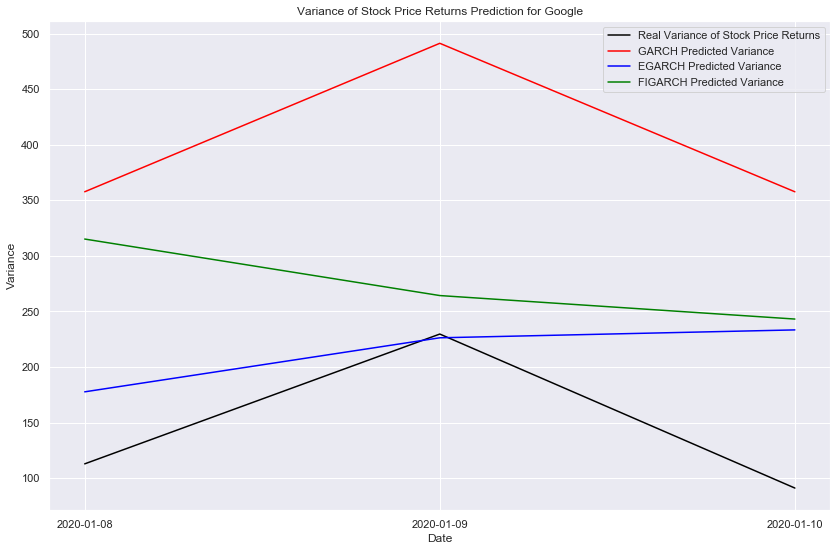

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,9))
plt.plot(fdf['Variance'], color = 'black', label = 'Real Variance of Stock Price Returns')
plt.plot(fdf['GARCH'], color = 'red', label = 'GARCH Predicted Variance')
plt.plot(fdf['EGARCH'], color = 'blue', label = 'EGARCH Predicted Variance')
plt.plot(fdf['FIGARCH'], color = 'green', label = 'FIGARCH Predicted Variance')
plt.title(f'Variance of Stock Price Returns Prediction for {stock}')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [38]:
fdf.to_excel(f"{stock} Forecasts.xlsx")